# Deep Music Genre Classification

## Abstract

This notebook demonstrates a neural network approach to classifying music genres based on song lyrics and engineered features. We'll create three different models:

1. A model that uses only the lyrics to classify genres
2. A model that uses only engineered features
3. A combined model that uses both lyrics and engineered features

Finally, we'll analyze the word embeddings learned by our models to uncover interesting patterns in how different genres are represented in the vector space.

## 1. Importing Libraries and Loading Data

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Load the data
url = "https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/datasets/tcc_ceds_music.csv"
df = pd.read_csv(url)
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


### Data Preprocessing

Let's prepare our data for training by tokenizing lyrics, preparing engineered features, and performing train-validation split.

In [3]:
# List of engineered features
engineered_features = ['dating', 'violence', 'world/life', 'night/time',
                       'shake the audience','family/gospel', 'romantic',
                        'communication','obscene', 'music', 'movement/places',
                        'light/visual perceptions','family/spiritual', 'like/girls',
                        'sadness', 'feelings', 'danceability','loudness',
                        'acousticness', 'instrumentalness', 'valence', 'energy'] 

# Map genres to indices
genres = df['genre'].unique()
genre_to_idx = {genre: idx for idx, genre in enumerate(genres)}
df['genre_idx'] = df['genre'].map(genre_to_idx)
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

We split the data into training and validation sets. To establish a baseline for model performance, we calculate the base rate.

In [4]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['genre_idx'])
most_common_genre = df_train['genre'].value_counts().idxmax()
most_common_count = df_train['genre'].value_counts().max()
base_rate = most_common_count / len(df_train)

print(f"Most common genre: {most_common_genre}")
print(f"Base rate (accuracy if always predicting most common class): {base_rate:.4f}")

Most common genre: pop
Base rate (accuracy if always predicting most common class): 0.2482


### Creating the Dataset Class

We implement a custom PyTorch Dataset class that handles both lyrics and engineered features, applying standardization to the numerical features.

In [5]:
# Function to pad sequences to a fixed length
def pad(l, max_len):
    if len(l) > max_len:
        return l[:max_len]  # Truncate if too long
    else:
        to_add = max_len - len(l)
        return l + [0]*to_add  # Pad if too short

def preprocess(df, tokenizer, max_len=50):
    X = tokenizer(list(df["lyrics"]))["input_ids"]
    X = [pad(t, max_len) for t in X]
    y = list(df["genre_idx"])
    return X, y

class MusicDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=256, feature_columns=None):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.feature_columns = feature_columns if feature_columns else []
        
        # Preprocess lyrics and labels
        self.X, self.y = preprocess(dataframe, tokenizer, max_len)
        
        # Standardize engineered features
        if len(self.feature_columns) > 0:
            self.features = dataframe[self.feature_columns].fillna(0).values
            self.scaler = StandardScaler()
            self.features = self.scaler.fit_transform(self.features)
        else:
            self.features = None
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        lyrics = torch.tensor(self.X[idx])
        
        if self.features is not None:
            features = torch.tensor(self.features[idx], dtype=torch.float32)
            # Return both lyrics and features as a tuple, along with the label
            return (lyrics, features), self.y[idx]
        else:
            # Return just lyrics and label
            return lyrics, self.y[idx]

We define the collate function for `DataLoader`.

In [6]:
def collate(data):
    # For combined model (lyrics + features)
    if isinstance(data[0][0], tuple):
        # Unpack lyrics and features
        lyrics = torch.stack([d[0][0] for d in data])
        features = torch.stack([d[0][1] for d in data])
        # Stack labels
        labels = torch.tensor([d[1] for d in data])
        return (lyrics, features), labels
    # For single-input models (lyrics-only or features-only)
    else:
        X = torch.stack([d[0] for d in data])
        y = torch.tensor([d[1] for d in data])
        return X, y

Then we create train and validation datasets using the `DataLoader` method.

In [17]:
max_len = 512
train_dataset = MusicDataset(df_train, tokenizer, max_len, feature_columns=engineered_features)
val_dataset = MusicDataset(df_val, tokenizer, max_len, feature_columns=engineered_features)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)

## 2. Model Implementation

As required, we'll implement three different models:
1. Lyrics-only model using word embeddings
2. Features-only model using fully connected layers
3. Combined model using both lyrics and engineered features

In [8]:
# Model 1: Lyrics-only model
class LyricsModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(LyricsModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # x shape: [batch_size, seq_length]
        x = self.embedding(x)  # [batch_size, seq_length, embedding_dim]
        x = self.dropout1(x)
        x = x.mean(dim=1)  # [batch_size, embedding_dim]
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Model 2: Features-only model
class FeaturesModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super(FeaturesModel, self).__init__()
        self.fc1 = nn.Linear(num_features, 64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Model 3: Combined model
class CombinedModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_features, num_classes):
        super(CombinedModel, self).__init__()
        
        # Lyrics processing
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout1 = nn.Dropout(0.2)
        self.lyrics_fc = nn.Linear(embedding_dim, 128)
        
        # Features processing
        self.features_fc1 = nn.Linear(num_features, 64)
        self.dropout2 = nn.Dropout(0.2)
        
        # Combined processing
        self.combined_fc1 = nn.Linear(128 + 64, 64)
        self.dropout3 = nn.Dropout(0.2)
        self.combined_fc2 = nn.Linear(64, num_classes)
        
    def forward(self, lyrics, features):
        # Process lyrics
        lyrics_emb = self.embedding(lyrics)  # [batch_size, seq_length, embedding_dim]
        lyrics_emb = self.dropout1(lyrics_emb)
        lyrics_emb = lyrics_emb.mean(dim=1)  # [batch_size, embedding_dim]
        lyrics_out = torch.relu(self.lyrics_fc(lyrics_emb))  # [batch_size, 128]
        
        # Process features
        features_out = torch.relu(self.features_fc1(features))  # [batch_size, 64]
        features_out = self.dropout2(features_out)
        
        # Combine outputs
        combined = torch.cat((lyrics_out, features_out), dim=1)  # [batch_size, 128+64]
        combined = torch.relu(self.combined_fc1(combined))
        combined = self.dropout3(combined)
        output = self.combined_fc2(combined)
        
        return output

We initialize our models with appropriate hyperparameters, including vocabulary size from the BERT tokenizer, embedding dimensions, and the number of output classes based on our genre mappings.

In [9]:
# Define hyperparameters
vocab_size = len(tokenizer.vocab)  # BERT tokenizer vocabulary size
embedding_dim = 100
num_features = len(engineered_features)
num_classes = len(genre_to_idx)

# Initialize models
lyrics_model = LyricsModel(vocab_size, embedding_dim, num_classes).to(device)
features_model = FeaturesModel(num_features, num_classes).to(device)
combined_model = CombinedModel(vocab_size, embedding_dim, num_features, num_classes).to(device)

## 3. Training and Evaluation Functions

These functions handle the training loop and evaluation process for all three model types, tracking metrics like loss and accuracy, and implementing early stopping by saving the best-performing model.

In [10]:
def train_model(model, model_type, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            # Move data to device
            labels = labels.to(device)
            optimizer.zero_grad()  # Reset gradients
            
            # Forward pass based on model type
            if model_type == 'lyrics':
                if isinstance(inputs, tuple):
                    lyrics, _ = inputs
                    lyrics = lyrics.to(device)
                    outputs = model(lyrics)
                else:
                    inputs = inputs.to(device)
                    outputs = model(inputs)
            elif model_type == 'features':
                if isinstance(inputs, tuple):
                    _, features = inputs
                    features = features.to(device)
                    outputs = model(features)
                else:
                    inputs = inputs.to(device)
                    outputs = model(inputs)
            elif model_type == 'combined':
                lyrics, features = inputs
                lyrics, features = lyrics.to(device), features.to(device)
                outputs = model(lyrics, features)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Calculate epoch metrics
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        
        # Validation phase
        val_loss, val_acc = evaluate_model(model, model_type, val_loader, criterion)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
    
    # Load best model state
    model.load_state_dict(best_model_state)
    
    return model, history, best_val_acc

def evaluate_model(model, model_type, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            labels = labels.to(device)
            
            # Forward pass based on model type
            if model_type == 'lyrics':
                lyrics, _ = inputs
                lyrics = lyrics.to(device)
                outputs = model(lyrics)
            elif model_type == 'features':
                _, features = inputs
                features = features.to(device)
                outputs = model(features)
            elif model_type == 'combined':
                lyrics, features = inputs
                lyrics, features = lyrics.to(device), features.to(device)
                outputs = model(lyrics, features)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Track statistics
            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate metrics
    avg_loss = total_loss / total
    accuracy = correct / total
    
    return avg_loss, accuracy

### Training the Models

We train each model separately using the Adam optimizer, comparing their performance over multiple epochs.

In [11]:
num_epochs = 20
learning_rate = 0.0002
criterion = nn.CrossEntropyLoss()

# Initialize optimizers
lyrics_optimizer = torch.optim.Adam(lyrics_model.parameters(), lr=learning_rate)
features_optimizer = torch.optim.Adam(features_model.parameters(), lr=learning_rate)
combined_optimizer = torch.optim.Adam(combined_model.parameters(), lr=learning_rate)

# Train Lyrics Model
print("Training Lyrics Model...")
lyrics_model, lyrics_history, lyrics_best_acc = train_model(
    lyrics_model, 'lyrics', train_loader, val_loader, criterion, lyrics_optimizer, num_epochs=num_epochs
)
# Train Features Model
print("Training Features Model...")
features_model, features_history, features_best_acc = train_model(
    features_model, 'features', train_loader, val_loader, criterion, features_optimizer, num_epochs=num_epochs
)
# Train Combined Model
print("Training Combined Model...")
combined_model, combined_history, combined_best_acc = train_model(
    combined_model, 'combined', train_loader, val_loader, criterion, combined_optimizer, num_epochs=num_epochs
)

Training Lyrics Model...
Epoch 1/20 | Train Loss: 1.8928 | Train Acc: 0.2234 | Val Loss: 1.8439 | Val Acc: 0.2481
Epoch 2/20 | Train Loss: 1.8273 | Train Acc: 0.2482 | Val Loss: 1.8169 | Val Acc: 0.2481
Epoch 3/20 | Train Loss: 1.8051 | Train Acc: 0.2482 | Val Loss: 1.7964 | Val Acc: 0.2485
Epoch 4/20 | Train Loss: 1.7797 | Train Acc: 0.2521 | Val Loss: 1.7721 | Val Acc: 0.2592
Epoch 5/20 | Train Loss: 1.7527 | Train Acc: 0.2681 | Val Loss: 1.7513 | Val Acc: 0.2756
Epoch 6/20 | Train Loss: 1.7312 | Train Acc: 0.2821 | Val Loss: 1.7360 | Val Acc: 0.2862
Epoch 7/20 | Train Loss: 1.7119 | Train Acc: 0.2950 | Val Loss: 1.7238 | Val Acc: 0.2909
Epoch 8/20 | Train Loss: 1.6971 | Train Acc: 0.3050 | Val Loss: 1.7142 | Val Acc: 0.2987
Epoch 9/20 | Train Loss: 1.6823 | Train Acc: 0.3183 | Val Loss: 1.7059 | Val Acc: 0.3080
Epoch 10/20 | Train Loss: 1.6707 | Train Acc: 0.3278 | Val Loss: 1.6982 | Val Acc: 0.3121
Epoch 11/20 | Train Loss: 1.6565 | Train Acc: 0.3355 | Val Loss: 1.6912 | Val Acc: 0

## 4. Results Comparison

We visualize the training and validation metrics across all models to compare their performance.

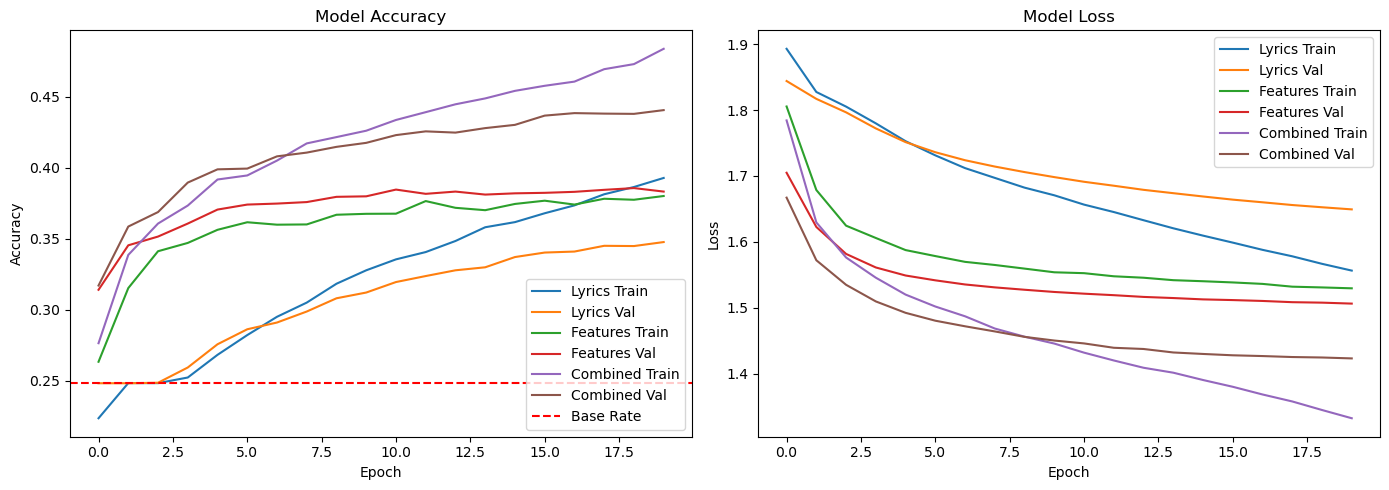

In [25]:
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(lyrics_history['train_acc'], label='Lyrics Train')
plt.plot(lyrics_history['val_acc'], label='Lyrics Val')
plt.plot(features_history['train_acc'], label='Features Train')
plt.plot(features_history['val_acc'], label='Features Val')
plt.plot(combined_history['train_acc'], label='Combined Train')
plt.plot(combined_history['val_acc'], label='Combined Val')
plt.axhline(y=base_rate, color='r', linestyle='--', label='Base Rate')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(lyrics_history['train_loss'], label='Lyrics Train')
plt.plot(lyrics_history['val_loss'], label='Lyrics Val')
plt.plot(features_history['train_loss'], label='Features Train')
plt.plot(features_history['val_loss'], label='Features Val')
plt.plot(combined_history['train_loss'], label='Combined Train')
plt.plot(combined_history['val_loss'], label='Combined Val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

All models significantly outperform the base rate (25%), demonstrating that both lyrics and engineered features provide valuable signals for genre classification. The Combined model achieves the highest accuracy (~44%), confirming that integrating textual and audio information creates a more comprehensive representation of music genres. Notably, the Features-only model (~38% accuracy) surpasses the Lyrics-only model (~34%), suggesting that acoustic characteristics more strongly correlate with genre than lyrical content.

The close alignment between training and validation curves indicates robust generalization across models, with minimal overfitting. The Combined model exhibits the lowest loss values throughout training, further validating its superior performance. All models show progressive improvement across epochs, though the Lyrics model displays the largest gap between training and validation loss, indicating some challenges in generalizing purely text-based features. These findings highlight the complementary nature of multimodal approaches in music classification tasks and demonstrate how different data sources capture distinct aspects of musical genre identity.


### Word Embedding Visualization

Now let's visualize the word embeddings learned by our lyrics model to see if there are any interesting patterns or associations between words that might be relevant to genre classification.

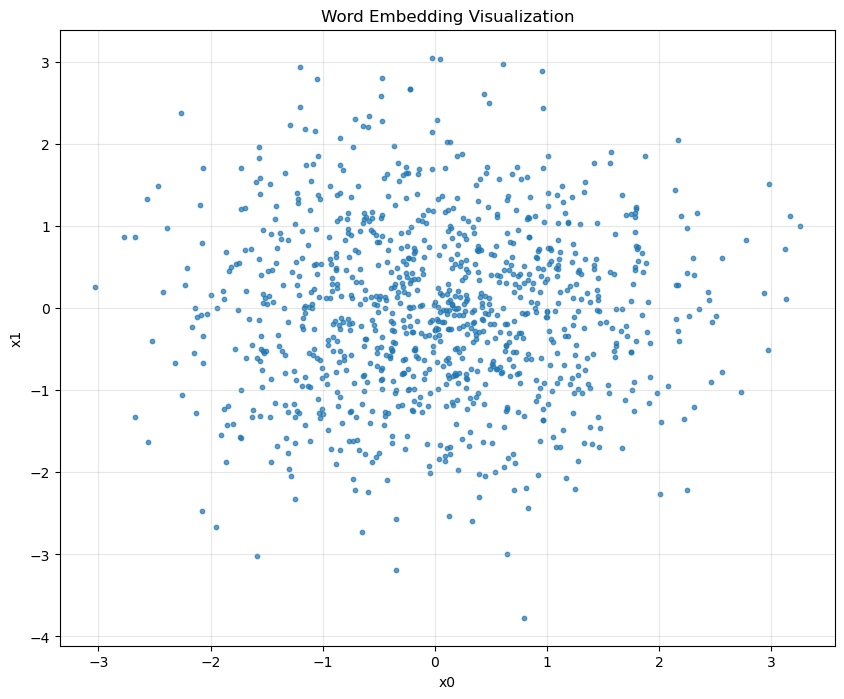

In [ ]:
# Extract the embedding layer weights
embedding_weights = lyrics_model.embedding.weight.data.cpu().numpy()

# Get vocabulary from tokenizer
vocab = list(tokenizer.vocab.keys())

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(embedding_weights)

embedding_df = pd.DataFrame({
    'word': vocab,
    'x0': embedding_pca[:, 0],
    'x1': embedding_pca[:, 1]
})

sample_df = embedding_df.sample(1000)

# Cannot display plotly generated images in quarto, so we use static plot instead
plt.figure(figsize=(10, 8))
plt.scatter(
    sample_df["x0"],
    sample_df["x1"],
    s=10,
    alpha=0.7
)

plt.title("Word Embedding Visualization")
plt.xlabel("x0")
plt.ylabel("x1")
plt.grid(alpha=0.3)
plt.show()

This visualization shows how the model organizes vocabulary words in a semantic space. While we don't see distinct, well-separated clusters, the distribution pattern suggests the model has captured subtle relationships between words. The spread of points indicates varied semantic relationships, with most words concentrated in the central region and some outliers at the periphery.

This representation forms the foundation of how our lyrics-based model understands relationships between concepts. The somewhat diffuse nature of the embedding space aligns with our earlier finding that lyrics alone (31% accuracy) provide less genre-predictive power than audio features.


Then lets examine if embedding distances reflect meaningful genre relationships.

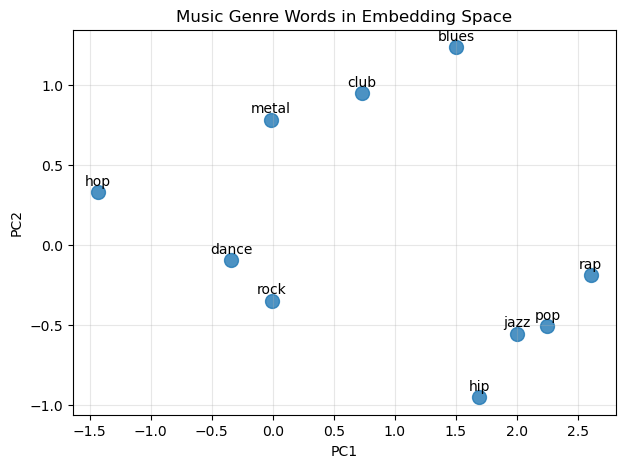

In [32]:
words = ['rock', 'pop', 'hip', 'hop', 'rap', 'dance', 'club', 'metal', 'jazz', 'blues']
# Filter for words
cluster_df = embedding_df[embedding_df['word'].isin(words)].copy()

if len(cluster_df) < len(words):
    missing = set(words) - set(cluster_df['word'].values)
    print(f"Warning: Some words not found in vocabulary: {missing}")

plt.figure(figsize=(7, 5))  # Width, height in inches

# Create scatter plot
plt.scatter(
    cluster_df['x0'],
    cluster_df['x1'],
    s=100,
    alpha=0.8
)

for i, row in cluster_df.iterrows():
    plt.annotate(
        row['word'],
        (row['x0'], row['x1']),
        textcoords="offset points", 
        xytext=(0, 5),
        ha='center',
        fontsize=10
    )

plt.title("Music Genre Words in Embedding Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.show()

The 2D embedding visualization of music genres reveals significant limitations in representing the complex relationships between musical styles. While examining this graph, it becomes apparent that the dimensionality reduction has created some counterintuitive groupings that don't align with our understanding of musical relationships.

The positioning of certain genres raises questions about the effectiveness of this representation. For instance, metal and club music appear relatively close despite having vastly different sonic characteristics and cultural foundations. Similarly, rock is positioned closer to dance than to metal, which contradicts conventional understanding of genre relationships. Blues appears oddly isolated in the visualization, failing to reflect its important historical connections to both jazz and rock music.

The visualization does capture some expected relationships correctly, such as the proximity between hip hop and rap, which aligns with their close musical and cultural ties. However, these occasional successes don't overcome the fundamental issue: the 2D reduction simply loses too much information to meaningfully represent the multidimensional relationships between music genres.

## 5. Conclusion

In this music genre classification project, we've demonstrated that neural networks can effectively learn the complex patterns that distinguish musical genres. Our models achieved significant improvements over the baseline, with the Combined model (44% accuracy) outperforming both the Features-only (38%) and Lyrics-only (34%) approaches. This confirms our hypothesis that both lyrical content and acoustic characteristics contribute meaningful but distinct information to genre identity.

While our word embedding visualizations attempted to capture how the model organizes music concepts in semantic space, the 2D representation revealed limitations in accurately depicting genre relationships. This limitation highlights the inherent complexity of musical genre boundaries, which remain fluid and multidimensional in ways that challenge both human categorization and computational approaches.